In [ ]:
import gdown # To download the file from Google Drive
import json
import re
import pandas as pd
import numpy as np
import random
import zipfile
import os
import glob
import multiprocessing
from multiprocessing import Pool, cpu_count, Lock
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from IPython.display import display, Math

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Getting the file from GDrive

In [ ]:
file_id = '1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE
From (redirected): https://drive.google.com/uc?id=1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE&confirm=t&uuid=a72f7881-2cfe-407f-acb1-79765483f96b
To: /content/dataset.zip
100%|██████████| 1.00G/1.00G [00:08<00:00, 112MB/s]


'dataset.zip'

## File Extraction and setting path for access

In [ ]:
zip_file_path = 'dataset.zip'
extraction_dir = '/content/dataset'

os.makedirs(extraction_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()

    with tqdm(total=len(file_list), desc='Extracting files') as pbar:
        for file in file_list:
            zip_ref.extract(file, extraction_dir)
            pbar.update(1)

Extracting files: 100%|██████████| 56530/56530 [00:56<00:00, 1005.25it/s]


## Extracting all texts from all abstracts

In [ ]:
extraction_dir = '/content/dataset/pdf_json'
json_files = [f for f in os.listdir(extraction_dir) if f.endswith('.json') and not f.endswith('.swp')]

# Function to process each JSON file
def process_file(file_name):
    file_path = os.path.join(extraction_dir, file_name)
    text_data = []

    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

            # Function to find "title" and "text", excluding certain contexts
            def extract_text(data):
                if isinstance(data, dict):
                    # Extract "abstract" and "body_text" text
                    if 'abstract' in data:
                        abstract = data['abstract']
                        if isinstance(abstract, list):
                            for item in abstract:
                                if isinstance(item, dict) and 'text' in item:
                                    text = item['text']
                                    if isinstance(text, str):
                                        text_data.append(text)

                    # Check and skip "cite_spans"
                    if 'cite_spans' in data:
                        # Skip extraction from "cite_spans"
                        return

                    for key, value in data.items():
                        extract_text(value)
                elif isinstance(data, list):
                    for item in data:
                        extract_text(item)

            extract_text(data)
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")

    return text_data

# Use multiprocessing to process files in parallel
def parallel_process(files, num_workers=4):
    with multiprocessing.Pool(num_workers) as pool:
        results = list(tqdm(pool.imap(process_file, files), total=len(files)))
    return results

In [ ]:
corpus_file_path = '/content/corpus.txt'
results = parallel_process(json_files)

# Flatten the list of results and combine all text
corpus = [text for sublist in results for text in sublist]

# Save the corpus to a text file
with open('/content/dataset/corpus.txt', 'w', encoding='utf-8') as corpus_file:
    for text in corpus:
        corpus_file.write(text + '\n')

100%|██████████| 56528/56528 [00:14<00:00, 3808.27it/s]


In [ ]:
print(f"Before processing, corpus size is {round(os.path.getsize('/content/dataset/corpus.txt') / (1024 ** 2), 2)} MB")

Before processing, corpus size is 57.15 MB


In [ ]:
input_file_path = '/content/dataset/corpus.txt'
output_file_path = '/content/dataset/corpus_cleaned.txt'

In [ ]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Function to check if a token contains any alphabetic characters and no numbers
def contains_alphabet_and_no_numbers(token):
    return any(char.isalpha() for char in token) and not any(char.isdigit() for char in token)

# Function to remove tokens that do not contain any alphabetic characters and contain numbers
def remove_non_alpha_and_numbers_tokens(tokens):
    return [
        token for token in tokens
        if (contains_alphabet_and_no_numbers(token) and
            not re.search(r'[\u0370-\u03FF]', token) and
            not re.fullmatch(r"\w*'s", token) and
            token not in stop_words)
    ]

# Function to remove punctuation from the tokens
def remove_punctuation(tokens):
    return [token for token in tokens if token not in string.punctuation]

# Function to remove URLs from the text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

# Function to clean and process each line
def process_line(line):
    line = line.lower()
    line = remove_urls(line)

    tokens = word_tokenize(line)
    tokens = remove_punctuation(tokens)

    cleaned_tokens = remove_non_alpha_and_numbers_tokens(tokens)

    # Remove words shorter than 3 characters
    cleaned_tokens = [token for token in cleaned_tokens if len(token) >= 3]

    cleaned_line = ' '.join(cleaned_tokens)

    return cleaned_line if cleaned_line.strip() else None

In [ ]:
def main():
    input_file_path = '/content/dataset/corpus.txt'
    output_file_path = '/content/dataset/corpus_cleaned.txt'

    with open(input_file_path, 'r') as file:
        lines = file.readlines()

    with Pool(cpu_count()) as pool:
        processed_lines = list(tqdm(pool.imap(process_line, lines), total=len(lines), desc='Processing Lines'))

    with open(output_file_path, 'w') as file:
        for line in processed_lines:
            if line:
                file.write(line + '\n')

    print(f"Cleaned text has been saved to {output_file_path}.")

if __name__ == "__main__":
    main()

Processing Lines: 100%|██████████| 78470/78470 [00:05<00:00, 15260.99it/s]


Cleaned text has been saved to /content/dataset/corpus_cleaned.txt.


In [ ]:
print(f"After processing corpus size is {round(os.path.getsize('/content/dataset/corpus_cleaned.txt') / (1024 ** 2), 2)} MB")

After processing corpus size is 41.84 MB


In [ ]:
with open('/content/dataset/corpus_cleaned.txt', 'r') as file:
    text = file.read()

words = text.split()  # Basic tokenization by whitespace

unique_words = set(words)

vocabulary_size = len(unique_words)

print(f'Total vocabulary size: {vocabulary_size}')

Total vocabulary size: 172398


In [ ]:
len(words)

5083178

# Assignment 4

## Task 1
Extract all the abstracts from the COVID-19 text files and use them as the corpus. Ensure that you create
a vocabulary of around 10,000 words

In [ ]:
def count_words(chunk):
    # Count occurrences of each word in the chunk
    return Counter(chunk)

if __name__ == '__main__':
    num_chunks = min(4, len(words))
    chunk_size = max(1, len(words) // num_chunks)

    # Create chunks from the words list
    chunks = [words[i:i + chunk_size] for i in range(0, len(words), chunk_size)]

    with Pool() as pool:
        results = list(tqdm(pool.imap(count_words, chunks), total=len(chunks)))

    total_counter = Counter()
    for result in results:
        total_counter.update(result)

    # Filter for words with occurrences greater than 30
    filtered_words = {word: count for word, count in total_counter.items() if count > 30}

    # Store the result as a list of tuples (word, count)
    vocab_list = list(filtered_words.items())

100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


In [ ]:
# Vocabulary of around 10,000 words
len(vocab_list)

12085

In [ ]:
# Create a mapping form word to index
word_to_index = {word: idx for idx, word in enumerate(vocab_list)}

## Task 2: Construct One-Hot Vectors (OHVs)
You may construct each one on the fly (just in time) during training, or you can pre-create and store
them in memory (volatile or non-volatile). If you associate numerical indexes with the vocabulary, you can
generate each OHV on demand during training.

In [ ]:
# Using indices for one-hot vector creation (indexing method)
def retrieve_token_index(token):
    if token in word_to_index:
        return word_to_index[token]
    else:
        return None

In [ ]:
# Create one-hot vectors for the vocabulary
def create_one_hot_vectors(vocab):
    one_hot_vectors = {}
    for word in vocab:
        one_hot_vector = np.zeros(len(vocab))
        one_hot_vector[word_to_index[word]] = 1
        one_hot_vectors[word] = one_hot_vector
    return one_hot_vectors

# Generate one-hot vectors
one_hot_vectors = create_one_hot_vectors(vocab_list)

## Task 3: Describe Your Architecture
Provide a brief description of the architecture used. Use appropriate markdown or formatting to emphasize
key design decisions. Optionally, you can include a figure illustrating your neural network architecture,
with explanations, instead of text.

### SGD Architecture for Linear Model Training

- **Algorithm**: Implements stochastic gradient descent (SGD) for a linear model.
- **Input Representation**: Uses one-hot encoding for vocabulary tokens.
- **Weight Initialization**: Randomly initializes weights based on the vocabulary size.
- **Error Calculation**: Computes estimated output and error from actual target output.
- **Weight Update**: Adjusts weights using the error and learning rate.
- **Loss Monitoring**: Calculates Mean Squared Error (MSE) to track performance.
- **Training Loop**: Iterates over epochs, updating weights and storing average loss for visualization.

## Task 4: Use Stochastic Gradient Descent (SGD)
Apply the SGD algorithm for learning in your model.

## Task 5: Plot Epochs vs. Training Error
Plot the relationship between the number of epochs and the training error.

In [ ]:
# For single step of gradient descent
def execute_sgd_iteration(input_data, target_output, existing_weights, learning_rate):
    """
    For execution of one step of stochastic gradient descent.
    """
    estimated_output = np.dot(existing_weights, input_data)
    error = estimated_output - target_output
    weight_updates = error * input_data
    new_weights = existing_weights - learning_rate * weight_updates  # Update weights
    return new_weights

In [ ]:
def optimize_model_with_sgd(vocab_list, learning_rate=0.01, num_epochs=100):
    """
    Training the model using SGD and getting the average loss for each epoch.
    """
    # Vocabulary index
    token_to_index = {token: index for index, (token, _) in enumerate(vocab_list)}

    total_tokens = len(token_to_index)

    # Random weights
    weight_vector = np.random.randn(total_tokens)

    average_losses = []

    for epoch in range(num_epochs):
        cumulative_loss = 0

        # Perform SGD for each token in the vocabulary
        for token, count in vocab_list:
            token_index = token_to_index.get(token)
            if token_index is not None:
                # One-hot vector
                one_hot_vector = np.zeros(total_tokens)
                one_hot_vector[token_index] = 1

                # Perform SGD step using `execute_sgd_iteration`
                weight_vector = execute_sgd_iteration(one_hot_vector, count, weight_vector, learning_rate)

                # Calculate Mean Squared Error loss for monitoring
                predicted_output = np.dot(weight_vector, one_hot_vector)
                loss = (predicted_output - count) ** 2
                cumulative_loss += loss

        avg_loss = cumulative_loss / total_tokens
        average_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), average_losses, marker='o')
    plt.title("Epochs vs. Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.show()

Epoch 1/500, Loss: 1263706.7230
Epoch 2/500, Loss: 1238558.9592
Epoch 3/500, Loss: 1213911.6359
Epoch 4/500, Loss: 1189754.7944
Epoch 5/500, Loss: 1166078.6740
Epoch 6/500, Loss: 1142873.7084
Epoch 7/500, Loss: 1120130.5216
Epoch 8/500, Loss: 1097839.9242
Epoch 9/500, Loss: 1075992.9097
Epoch 10/500, Loss: 1054580.6508
Epoch 11/500, Loss: 1033594.4958
Epoch 12/500, Loss: 1013025.9654
Epoch 13/500, Loss: 992866.7487
Epoch 14/500, Loss: 973108.7004
Epoch 15/500, Loss: 953743.8372
Epoch 16/500, Loss: 934764.3349
Epoch 17/500, Loss: 916162.5246
Epoch 18/500, Loss: 897930.8904
Epoch 19/500, Loss: 880062.0656
Epoch 20/500, Loss: 862548.8305
Epoch 21/500, Loss: 845384.1088
Epoch 22/500, Loss: 828560.9650
Epoch 23/500, Loss: 812072.6018
Epoch 24/500, Loss: 795912.3571
Epoch 25/500, Loss: 780073.7012
Epoch 26/500, Loss: 764550.2345
Epoch 27/500, Loss: 749335.6848
Epoch 28/500, Loss: 734423.9047
Epoch 29/500, Loss: 719808.8690
Epoch 30/500, Loss: 705484.6725
Epoch 31/500, Loss: 691445.5275
Epoch

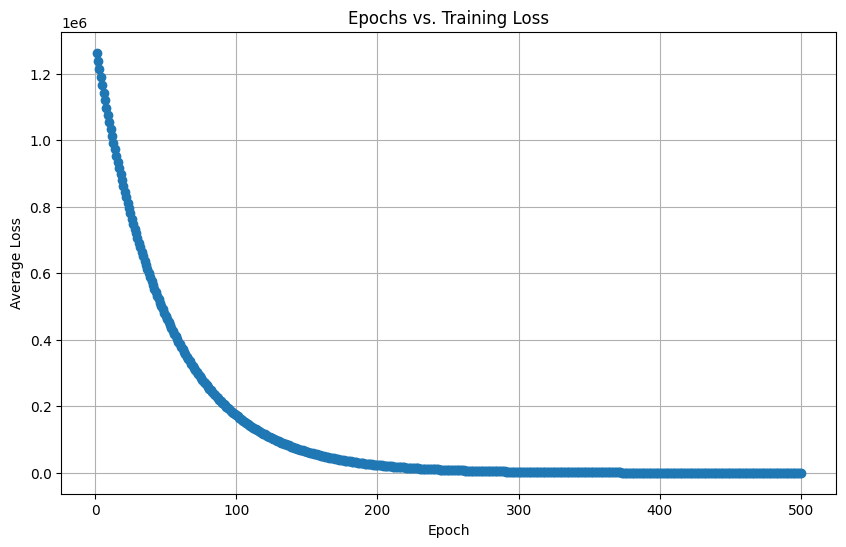

In [ ]:
optimize_model_with_sgd(vocab_list, learning_rate=0.01, num_epochs=500)

## Task 6: Use Negative Sampling
Replace naive softmax with negative sampling (use five negative samples per training instance)

In [ ]:
# For performing a single step of gradient descent using negative sampling
def execute_negative_sampling_step(word_index_input, target_value, input_matrix, output_matrix, learning_rate, neg_samples):
    """
    For execution of one step of gradient descent with negative sampling, updating both W_in and W_out.
    """
    vector_input = input_matrix[:, word_index_input]  # Embedding for the input word from the input matrix

    # Positive target (correct word)
    predicted_output = np.dot(output_matrix[word_index_input], vector_input)
    error_prediction = predicted_output - target_value

    # Update output matrix for the positive sample
    output_matrix[word_index_input] -= learning_rate * error_prediction * vector_input

    # Update input matrix for the input word
    input_matrix[:, word_index_input] -= learning_rate * np.dot(output_matrix[word_index_input].T, error_prediction)

    # Negative samples update
    for sample_neg in neg_samples:
        predicted_neg_output = np.dot(output_matrix[sample_neg], vector_input)  # Prediction for negative sample
        error_neg = predicted_neg_output - 0

        # Update output matrix for the negative sample
        output_matrix[sample_neg] -= learning_rate * error_neg * vector_input

        # Update input matrix based on negative sample
        input_matrix[:, sample_neg] -= learning_rate * np.dot(output_matrix[sample_neg].T, error_neg)

    return input_matrix, output_matrix

def select_negative_words(word_index_map, num_samples=5):
    """
    Randomly sampling negative words from the vocabulary.
    """
    all_words = list(word_index_map.keys())
    return random.sample(all_words, num_samples)

# Function to train the model using SGD with negative sampling
def train_model_with_sgd_and_negative_sampling(vocab_list, learning_rate=0.01, num_epochs=100, num_neg_samples=5):
    """
    Trains a Skip-gram model using SGD with negative sampling and updates input and output matrices.
    """
    word_index_map = {word: idx for idx, (word, _) in enumerate(vocab_list)}

    vocab_size = len(word_index_map)
    embedding_dim = 128  # Size of the embedding vector

    # Random input and output matrices
    input_matrix = np.random.randn(embedding_dim, vocab_size)
    output_matrix = np.random.randn(vocab_size, embedding_dim)

    # Dummy target value for each word (1.0 for simplicity)
    target_value = 1.0

    avg_epoch_losses = []

    for epoch in range(num_epochs):
        total_loss = 0

        # Prepare lists for batch processing
        all_indices = list(word_index_map.values())
        random.shuffle(all_indices)  # Shuffle the word indices for each epoch

        # Perform SGD for each word in the vocabulary
        for input_word_idx in all_indices:
            # Sample negative words
            negative_samples = select_negative_words(word_index_map, num_neg_samples)

            negative_indices = [word_index_map[neg_word] for neg_word in negative_samples]

            # Perform SGD step using negative sampling
            input_matrix, output_matrix = execute_negative_sampling_step(input_word_idx, target_value, input_matrix, output_matrix, learning_rate, negative_indices)

            # Mean Squared Error loss calculation for monitoring
            predicted_value = np.dot(output_matrix[input_word_idx], input_matrix[:, input_word_idx])
            loss = (predicted_value - target_value) ** 2
            total_loss += loss

        # Calculate and store average loss for the epoch
        avg_loss = total_loss / vocab_size
        avg_epoch_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), avg_epoch_losses, marker='o')
    plt.title("Epochs vs. Training Loss with Negative Sampling")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.show()

    return input_matrix, output_matrix

Epoch 1/50, Loss: 73.8918
Epoch 2/50, Loss: 46.2225
Epoch 3/50, Loss: 30.9379
Epoch 4/50, Loss: 23.1205
Epoch 5/50, Loss: 17.9838
Epoch 6/50, Loss: 15.2043
Epoch 7/50, Loss: 13.5912
Epoch 8/50, Loss: 12.5576
Epoch 9/50, Loss: 11.9335
Epoch 10/50, Loss: 11.2608
Epoch 11/50, Loss: 10.9977
Epoch 12/50, Loss: 10.6604
Epoch 13/50, Loss: 10.0443
Epoch 14/50, Loss: 9.8826
Epoch 15/50, Loss: 9.6007
Epoch 16/50, Loss: 9.6685
Epoch 17/50, Loss: 9.5363
Epoch 18/50, Loss: 9.3955
Epoch 19/50, Loss: 9.2424
Epoch 20/50, Loss: 8.8385
Epoch 21/50, Loss: 8.4761
Epoch 22/50, Loss: 8.4823
Epoch 23/50, Loss: 8.1872
Epoch 24/50, Loss: 7.9966
Epoch 25/50, Loss: 7.6855
Epoch 26/50, Loss: 7.6645
Epoch 27/50, Loss: 7.6005
Epoch 28/50, Loss: 7.4767
Epoch 29/50, Loss: 7.3292
Epoch 30/50, Loss: 7.1774
Epoch 31/50, Loss: 6.9916
Epoch 32/50, Loss: 6.7682
Epoch 33/50, Loss: 6.6172
Epoch 34/50, Loss: 6.5617
Epoch 35/50, Loss: 6.4173
Epoch 36/50, Loss: 6.2795
Epoch 37/50, Loss: 6.1022
Epoch 38/50, Loss: 5.9200
Epoch 39

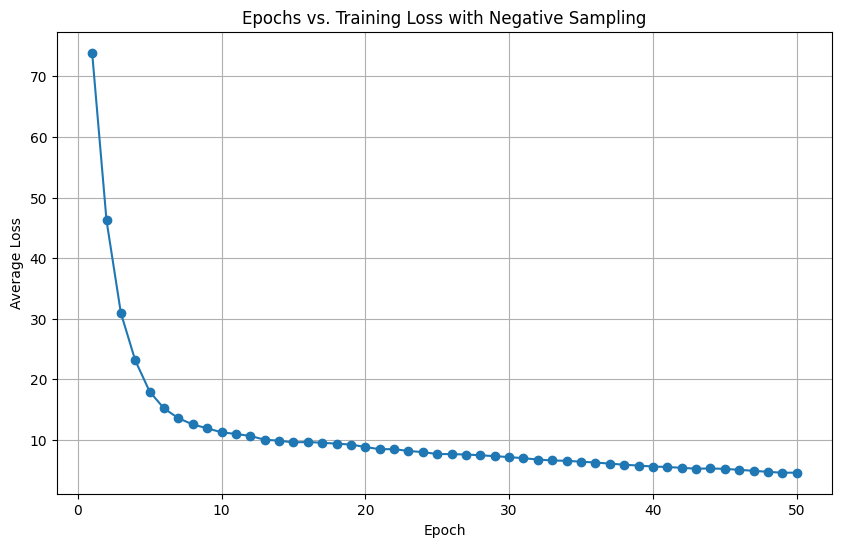

In [ ]:
# Train the model using negative sampling and retrieve W_in and W_out
win_matrix, wout_matrix = train_model_with_sgd_and_negative_sampling(vocab_list, learning_rate=0.001, num_epochs=50, num_neg_samples=5)

## Task 7: Test Analogies
Provide at least one example to test word analogies. The chosen words should not include the following
terms: ”man,” ”woman,” ”boy,” ”girl,” ”country,” ”city,” ”malware,” ”virus,” and their synonyms. Ensure
that two of the selected words used in the analogy are related to COVID-19.

In [ ]:
def create_vocab_index(vocab_list):
    word_to_index = {word: idx for idx, (word, _) in enumerate(vocab_list)}
    return word_to_index

def get_word_vector(word, word_to_index, embedding_matrix):
    index = word_to_index.get(word)
    if index is not None:
        return embedding_matrix[:, index]  # Return the column corresponding to the word
    print(f"Word '{word}' not found in vocabulary.")
    return None

def compute_similarity(vector_a, vector_b):
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    if norm_a == 0 or norm_b == 0:
        return -1
    return np.dot(vector_a, vector_b) / (norm_a * norm_b)

def perform_analogy(word_a, word_b, word_c, word_to_index, embedding_matrix):
    vec_a = get_word_vector(word_a, word_to_index, embedding_matrix)
    vec_b = get_word_vector(word_b, word_to_index, embedding_matrix)
    vec_c = get_word_vector(word_c, word_to_index, embedding_matrix)

    if vec_a is None or vec_b is None or vec_c is None:
        return None

    analogy_vector = vec_b - vec_a + vec_c
    best_word, highest_similarity = None, -np.inf

    for candidate_word, index in word_to_index.items():
        if candidate_word in (word_a, word_b, word_c):
            continue

        similarity = compute_similarity(embedding_matrix[:, index], analogy_vector)
        if similarity > highest_similarity:
            highest_similarity = similarity
            best_word = candidate_word

    return best_word

In [ ]:
def main():
    # Load vocabulary and embedding matrix
    word_to_index = create_vocab_index(vocab_list)
    embedding_matrix = win_matrix

    # Using words related to a specific topic
    word_a = "quarantine"
    word_b = "safety"
    word_c = "isolation"

    word_d = perform_analogy(word_a, word_b, word_c, word_to_index, embedding_matrix)
    if word_d:
        print(f"Analogy: '{word_a}' is to '{word_b}' as '{word_c}' is to '{word_d}'.")
    else:
        print("Analogy could not be computed due to missing words.")

if __name__ == "__main__":
    main()

Analogy: 'quarantine' is to 'safety' as 'isolation' is to 'precaution'.


# Assignment 5

## Task 1
Find similar words for a word of your choice using $W_{in}$

In [ ]:
def get_closest_terms(term, embeddings, vocab_list, num_results=5):
    # Create term_to_idx mapping from vocab_list
    term_to_idx = { (t, c): idx for idx, (t, c) in enumerate(vocab_list) }

    # Find the count for the term in vocab_list
    count = next((c for t, c in vocab_list if t == term), None)
    if count is None:
        print(f"Term '{term}' not found in vocabulary.")
        return None

    # Use the count to get the index
    idx = term_to_idx.get((term, count))
    if idx is None:
        print(f"Term '{term}' not found in vocabulary.")
        return None

    # Compute cosine similarity
    term_vector = embeddings[idx].reshape(1, -1)
    similarity_scores = cosine_similarity(term_vector, embeddings)[0]

    # Get the top-N most similar terms (excluding the term itself)
    closest_indices = np.argsort(-similarity_scores)[1:num_results+1]

    # Retrieve the corresponding terms from term_to_idx
    closest_terms = [
        (list(term_to_idx.keys())[i][0], similarity_scores[i])  # Use only the term part
        for i in closest_indices
    ]

    return closest_terms

In [ ]:
# Use case
term = "disease"

print(f"Similar terms to '{term}':")
closest_terms_win = get_closest_terms(term, win_matrix, vocab_list)
if closest_terms_win:
    for close_term, score in closest_terms_win:
        print(f"{close_term}: {score:.4f}")

Similar terms to 'disease':
strategies: 0.0280
identified: 0.0214
case: 0.0195
crucial: 0.0176
assessment: 0.0165


## Task 2
Find the similar words for the same word chosen in Task 1 using $W_{out}$

In [ ]:
print(f"\nSimilar words to '{term}' using Wout:")
similar_words_wout = get_closest_terms(term, wout_matrix, vocab_list)
if similar_words_wout:
    for sim_word, score in similar_words_wout:
        print(f"{sim_word}: {score:.4f}")


Similar words to 'disease' using Wout:
healing: 0.3722
therapists: 0.3235
persisting: 0.3176
intensities: 0.2957
biological: 0.2947


##Task 3
Find the similar words for the same word chosen in Task 1 after combining $W_{in}$ and $W_{out}$ - either concatenate them to have a longer vector or average them out.

In [ ]:
# Transpose InputMatrix to match the shape of OutputMatrix
output_matrix_transposed = wout_matrix.T

# Now combine them by averaging or concatenating
def merge_matrices(win_matrix, output_matrix_transposed, method='average'):
    if method == 'average':
        return (win_matrix + output_matrix_transposed) / 2
    elif method == 'concatenate':
        return np.hstack((win_matrix, output_matrix_transposed))
    else:
        raise ValueError("Invalid method. Use 'average' or 'concatenate'.")

# Combine InputMatrix and OutputMatrix (transposed) using the 'average' method
merged_matrix = merge_matrices(win_matrix, output_matrix_transposed, method='average')

In [ ]:
print(f"\nSimilar words to '{term}' using combined Win and Wout (average):")
similar_words_combined = get_closest_terms(term, merged_matrix, vocab_list)
if similar_words_combined:
    for sim_word, score in similar_words_combined:
        print(f"{sim_word}: {score:.4f}")


Similar words to 'disease' using combined Win and Wout (average):
strategies: 0.0230
avian: 0.0174
study: 0.0156
identified: 0.0154
stay: 0.0139


## Task 4
Compare the results of Task 1, Task 2 and Task 3 and write a brief description of the outcome

In [ ]:
win_terms = {close_term for close_term, _ in closest_terms_win}
wout_terms = {sim_word for sim_word, _ in similar_words_wout}
combined_terms = {sim_word for sim_word, _ in similar_words_combined}

# Prepare output
output = []

print("Word chosen:", term, "\n")

# Printing only from each list
only_win = win_terms - wout_terms - combined_terms
output.append(f"Words found only in W_in: {', '.join(only_win) if only_win else 'None'}")

only_wout = wout_terms - win_terms - combined_terms
output.append(f"Words found only in W_out: {', '.join(only_wout) if only_wout else 'None'}")

only_combined = combined_terms - win_terms - wout_terms
output.append(f"Words found only in Combined: {', '.join(only_combined) if only_combined else 'None'}")

# Common words in all lists
common_terms = win_terms & wout_terms & combined_terms
output.append(f"Common words in all: {', '.join(common_terms) if common_terms else 'None'}")

# Print the output
for line in output:
    print(line)

Word chosen: disease

W_in: strategies, identified, case, crucial, assessment
W_out: biological, intensities, persisting, healing, therapists
W_in and W_out combined: strategies, avian, study, identified, stay

Words found only in W_in: crucial, case, assessment
Words found only in W_out: biological, intensities, persisting, healing, therapists
Words found only in Combined: study, stay, avian
Common words in all: None


### Outcome Description

In Word2Vec, the **W_in** matrix captures the relationships of words based on their surrounding context (the words that precede them), while the **W_out** matrix focuses on co-occurrence with subsequent words (the words that follow). This dual approach allows for a richer representation of word meanings.

1. **Words Found Only in W_in**:
   - **"crucial," "case," "assessment"** emphasize the importance and evaluation of diseases, focusing on diagnostics and critical discussions.

2. **Words Found Only in W_out**:
   - **"biological," "intensities," "persisting," "healing," "therapists"** highlight therapeutic aspects and biological implications, reflecting treatment and healthcare contexts.

3. **Words Found Only in Combined**:
   - **"study," "stay," "avian"** suggest research contexts and specific classifications of diseases, capturing both analytical and contextual dimensions.

4. **Common Words in All**:
   - No common words indicate distinct contexts for "disease" in W_in and W_out, showcasing its multifaceted nature.

### Summary
This analysis illustrates the varied associations of "disease" based on different contexts, revealing its complexity across discussions. By leveraging both W_in and W_out, we gain a comprehensive understanding of the term's usage and implications.


## Task 5
A slide related to the complexities of skipgram and CBOW model was shown in the class. Check if they are correct. If not, what are the correct entries?

### Analyzing the Complexity of Skip-gram and CBOW Models

Here's a summary of the complexities associated with various model types and tasks:

1. **Skip-gram with Hierarchical Softmax:**  
   The time complexity is expressed as:  
   **O(T * N * C * log(V))**  
   This is valid since hierarchical softmax leverages a binary tree structure for log-probability calculations, resulting in logarithmic dependency on vocabulary size \( V \).

2. **Skip-gram with Negative Sampling:**  
   For this model, the complexity is:  
   **O(T * N * C * k)**  
   This reflects the reduction in computational load, as negative sampling focuses on \( k \) negative samples rather than the full vocabulary.

3. **CBOW with Hierarchical Softmax:**  
   The complexity is also:  
   **O(T * N * C * log(V))**  
   This matches the Skip-gram model using hierarchical softmax, as both methods employ a binary tree to approximate softmax, thus sharing the same logarithmic relationship with \( V \).

4. **CBOW with Negative Sampling:**  
   The complexity here is:  
   **O(T * N * C * k)**  
   Similar to the Skip-gram variant, this is correct because the computations are limited to dot products for \( k \) negative samples.

5. **Cosine Similarity:**  
   The complexity for calculating cosine similarity between vectors is:  
   **O(N)**  
   This is accurate, as determining cosine similarity requires a dot product and normalization of vectors, both of which scale linearly with the embedding size \( N \).

6. **Analogy Task:**  
   The complexity for performing an analogy task is:  
   **O(V * N)**  
   This is appropriate since it necessitates calculating similarities between the target vector and all vocabulary vectors, leading to complexity proportional to the product of vocabulary size \( V \) and embedding size \( N \).

### Summary:
The complexity assessments for Skip-gram, CBOW, cosine similarity, and analogy tasks are precise and require no modifications. These complexities effectively represent the performance of the models and tasks concerning vocabulary size, embedding dimensions, context window, and negative samples.
